In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import pickle
import os

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

K_FACTOR = 32  # Determines how quickly ratings change (can be adjusted)
HOME_ADVANTAGE = 100  # ELO points given to home team (can be adjusted)
INITIAL_ELO = 1500  # Starting ELO for all teams
REGRESSION_FACTOR = 0.75  # Season-to-season regression factor (can be adjusted)
RECENCY_BOOST_FACTOR = 0.2  # How much to increase K factor for recent games
MARGIN_SCALE = 0.5  # How much to scale margin of victory effect

In [ ]:
# BRADYBALL ELO - NCAA Basketball Rating System

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import pickle
import os

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define ELO calculation parameters - Feel free to adjust these
K_FACTOR = 32  # Base K-factor
HOME_ADVANTAGE = 100  # ELO points given to home team
INITIAL_ELO = 1500  # Starting ELO for all teams
RECENCY_BOOST_FACTOR = 0.2  # How much to increase K factor for recent games (0.2 = 20% boost for most recent games)
MARGIN_SCALE = 0.5  # How much to scale margin of victory effect

# Function to calculate expected win probability based on ELO difference
def expected_win_probability(team1_elo, team2_elo):
    """
    Calculate the expected win probability for team1 against team2.
    """
    return 1 / (1 + 10 ** ((team2_elo - team1_elo) / 400))

# Enhanced function to adjust K-factor based on margin of victory, opponent strength, and recency
def calculate_k_factor(base_k, margin, winner_elo, loser_elo, game_index, total_games):
    """
    Adjust K-factor based on:
    1. Margin of victory
    2. Opponent strength
    3. Recency of the game
    """
    # Calculate recency boost (more recent games have higher weight)
    recency_boost = 1.0 + (RECENCY_BOOST_FACTOR * game_index / total_games)
    
    # Calculate ELO difference
    elo_diff = winner_elo - loser_elo
    
    # Calculate expected margin based on ELO difference
    expected_margin = elo_diff / 25  # Approximate conversion
    
    # Calculate margin multiplier (capped to avoid extreme swings)
    if margin > expected_margin:
        # Exceeded expectations - bonus points
        margin_multiplier = 1.0 + min(MARGIN_SCALE * (margin - expected_margin) / 20, 1.0)
        
        # Scale based on opponent strength (beating stronger teams is worth more)
        if loser_elo > INITIAL_ELO:
            # Beating a strong team by a large margin gets extra bonus
            opponent_multiplier = 1.0 + 0.2 * (loser_elo - INITIAL_ELO) / 300
        else:
            # Beating a weak team doesn't get as much bonus, even with large margin
            opponent_multiplier = 1.0
    else:
        # Did not exceed expectations - less points
        margin_multiplier = 1.0
        opponent_multiplier = 1.0
    
    # Apply all multipliers to base K
    adjusted_k = base_k * recency_boost * margin_multiplier * opponent_multiplier
    
    return adjusted_k

# Function to update ELO ratings after a game
def update_elo(team1_elo, team2_elo, team1_win, k_factor=K_FACTOR, home_team=None):
    """
    Update ELO ratings for two teams after a game.
    """
    # Apply home court advantage
    adj_team1_elo = team1_elo
    adj_team2_elo = team2_elo
    
    if home_team == 1:
        adj_team1_elo += HOME_ADVANTAGE
    elif home_team == 2:
        adj_team2_elo += HOME_ADVANTAGE
    
    # Calculate expected win probabilities
    team1_expected = expected_win_probability(adj_team1_elo, adj_team2_elo)
    team2_expected = 1 - team1_expected
    
    # Calculate actual outcome (1 for win, 0 for loss)
    team1_actual = 1 if team1_win else 0
    team2_actual = 1 - team1_actual
    
    # Update ELO ratings
    team1_new_elo = team1_elo + k_factor * (team1_actual - team1_expected)
    team2_new_elo = team2_elo + k_factor * (team2_actual - team2_expected)
    
    return team1_new_elo, team2_new_elo

# Class to manage ELO ratings for all teams
class BradyballElo:
    def __init__(self, initial_elo=INITIAL_ELO):
        self.ratings = {}  # Dictionary to store team ratings
        self.peak_ratings = {}  # Dictionary to store peak ratings for teams
        self.history = {}  # Dictionary to store rating history
        self.initial_elo = initial_elo
        self.game_results = []  # Track all game results
        self.team_stats = {}  # Store additional team statistics
        
    def get_rating(self, team):
        """Get current rating for a team, or assign initial rating if not present"""
        if team not in self.ratings:
            # All teams start with the same initial ELO
            initial_rating = self.initial_elo
                
            self.ratings[team] = initial_rating
            self.peak_ratings[team] = initial_rating
            self.history[team] = [(datetime.now(), initial_rating)]
            
            # Initialize team stats
            self.team_stats[team] = {
                'games_played': 0,
                'wins': 0,
                'losses': 0,
                'home_wins': 0,
                'home_losses': 0,
                'away_wins': 0,
                'away_losses': 0,
                'neutral_wins': 0,
                'neutral_losses': 0,
                'points_scored': 0,
                'points_allowed': 0,
                'opponent_average_elo': 0,
                'strength_of_schedule': 0
            }
            
        return self.ratings[team]
    
    def update_ratings(self, team1, team2, team1_win, game_date, k_factor=K_FACTOR, 
                      home_team=None, margin=None, game_index=0, total_games=1):
        """Update ratings after a game with enhanced features"""
        team1_elo = self.get_rating(team1)
        team2_elo = self.get_rating(team2)
        
        # Determine winner and loser ELO for K-factor calculation
        if team1_win:
            winner_elo = team1_elo
            loser_elo = team2_elo
            winner = team1
            loser = team2
        else:
            winner_elo = team2_elo
            loser_elo = team1_elo
            winner = team2
            loser = team1
        
        # Calculate adjusted K-factor based on margin, opponent strength, and recency
        if margin is not None:
            k_factor = calculate_k_factor(
                k_factor, margin, winner_elo, loser_elo, game_index, total_games
            )
        
        # Update ratings
        team1_new_elo, team2_new_elo = update_elo(team1_elo, team2_elo, team1_win, k_factor, home_team)
        
        # Store new ratings
        self.ratings[team1] = team1_new_elo
        self.ratings[team2] = team2_new_elo
        
        # Update peak ratings
        self.peak_ratings[team1] = max(self.peak_ratings[team1], team1_new_elo)
        self.peak_ratings[team2] = max(self.peak_ratings[team2], team2_new_elo)
        
        # Store game result
        self.game_results.append({
            'date': game_date,
            'team1': team1,
            'team2': team2,
            'team1_elo_before': team1_elo,
            'team2_elo_before': team2_elo,
            'team1_elo_after': team1_new_elo,
            'team2_elo_after': team2_new_elo,
            'team1_win': team1_win,
            'k_factor': k_factor,
            'margin': margin
        })
        
        # Update history
        if isinstance(game_date, datetime):
            date_to_use = game_date
        else:
            date_to_use = datetime.now()
            
        self.history[team1].append((date_to_use, team1_new_elo))
        self.history[team2].append((date_to_use, team2_new_elo))
    
    def save_ratings(self, filename='bradyball_elo_ratings.pkl'):
        """Save current ratings to a file"""
        # Round ratings to two decimal places
        rounded_ratings = {team: round(rating, 2) for team, rating in self.ratings.items()}
        rounded_peak_ratings = {team: round(rating, 2) for team, rating in self.peak_ratings.items()}
        
        # Round historical ratings
        rounded_history = {}
        for team, history_list in self.history.items():
            rounded_history[team] = [(date, round(rating, 2)) for date, rating in history_list]
            
        # Round ratings in game results
        for game in self.game_results:
            game['team1_elo_before'] = round(game['team1_elo_before'], 2)
            game['team2_elo_before'] = round(game['team2_elo_before'], 2)
            game['team1_elo_after'] = round(game['team1_elo_after'], 2)
            game['team2_elo_after'] = round(game['team2_elo_after'], 2)
            game['k_factor'] = round(game['k_factor'], 2)
        
        # Overwrite existing file
        with open(filename, 'wb') as f:
            pickle.dump({
                'ratings': rounded_ratings,
                'peak_ratings': rounded_peak_ratings,
                'history': rounded_history,
                'game_results': self.game_results
            }, f)
        print(f"Ratings saved to {filename}")
            
    def load_ratings(self, filename='bradyball_elo_ratings.pkl'):
        """Load ratings from a file"""
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                data = pickle.load(f)
                self.ratings = data['ratings']
                self.peak_ratings = data['peak_ratings']
                self.history = data['history']
                self.game_results = data['game_results']
            print(f"Loaded ratings from {filename}")
            return True
        print(f"File {filename} not found")
        return False
    
    def get_top_teams(self, n=25, use_peak=False):
        """Get the top N teams by ELO rating"""
        if use_peak:
            ratings_to_use = self.peak_ratings
        else:
            ratings_to_use = self.ratings
            
        sorted_teams = sorted(ratings_to_use.items(), key=lambda x: x[1], reverse=True)
        return sorted_teams[:n]
    
    def plot_rating_history(self, teams, title="BRADYBALL ELO Rating History"):
        """Plot rating history for selected teams"""
        plt.figure(figsize=(14, 8))
        
        # Determine common date range for all teams
        all_dates = []
        for team in teams:
            if team in self.history:
                dates, _ = zip(*self.history[team])
                all_dates.extend(dates)
        
        # No need to filter if we're showing all dates
        date_range = sorted(list(set(all_dates))) if all_dates else []
        
        # Plot each team's history
        for team in teams:
            if team in self.history:
                dates, ratings = zip(*self.history[team])
                
                # Use date indices for more consistent x-axis spacing
                date_indices = [date_range.index(date) if date in date_range else -1 for date in dates]
                valid_indices = [(i, r) for i, r in zip(date_indices, ratings) if i >= 0]
                
                if valid_indices:
                    x_values, y_values = zip(*valid_indices)
                    plt.plot(x_values, y_values, marker='o', linestyle='-', label=team)
        
        # Customize the plot
        plt.title(title)
        plt.xlabel('Game Number')
        plt.ylabel('ELO Rating')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        
        # Add horizontal line at initial ELO
        plt.axhline(y=self.initial_elo, color='r', linestyle='--', alpha=0.3, label='Initial ELO')
        
        return plt
    
    def plot_rating_distribution(self, title="BRADYBALL ELO Rating Distribution"):
        """Plot histogram of current team ratings"""
        plt.figure(figsize=(12, 8))
        
        ratings = list(self.ratings.values())
        
        # Calculate basic statistics
        mean_rating = np.mean(ratings)
        median_rating = np.median(ratings)
        std_dev = np.std(ratings)
        
        # Create histogram with KDE
        sns.histplot(ratings, kde=True, bins=20)
        
        # Add vertical lines for key values
        plt.axvline(x=self.initial_elo, color='r', linestyle='--', 
                label=f'Initial ELO ({self.initial_elo})')
        plt.axvline(x=mean_rating, color='g', linestyle='-', 
                label=f'Mean ({mean_rating:.2f})')
        plt.axvline(x=median_rating, color='b', linestyle=':', 
                label=f'Median ({median_rating:.2f})')
        
        # Add statistical info to title
        stats_info = f"\nMean: {mean_rating:.2f}, Median: {median_rating:.2f}, Std Dev: {std_dev:.2f}"
        plt.title(title + stats_info)
        
        plt.xlabel('ELO Rating')
        plt.ylabel('Number of Teams')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        return plt
    
    def get_team_summary(self, team):
        """Get summary statistics for a specific team"""
        if team not in self.ratings:
            return None
            
        # Get all games for this team
        team_games = [g for g in self.game_results 
                     if g['team1'] == team or g['team2'] == team]
        
        # Calculate wins and losses
        wins = sum(1 for g in team_games 
                  if (g['team1'] == team and g['team1_win']) or 
                     (g['team2'] == team and not g['team1_win']))
        
        losses = len(team_games) - wins
        
        # Calculate rating change
        initial_rating = self.initial_elo
        current_rating = self.ratings[team]
        rating_change = current_rating - initial_rating
        
        # Calculate average opponent rating
        opponent_ratings = []
        for g in team_games:
            if g['team1'] == team:
                opponent_ratings.append(g['team2_elo_before'])
            else:
                opponent_ratings.append(g['team1_elo_before'])
                
        avg_opponent_rating = sum(opponent_ratings) / len(opponent_ratings) if opponent_ratings else 0
        
        return {
            'team': team,
            'current_elo': current_rating,
            'peak_elo': self.peak_ratings[team],
            'elo_change': rating_change,
            'wins': wins,
            'losses': losses,
            'games_played': len(team_games),
            'avg_opponent_rating': avg_opponent_rating
        }

# Function to parse NCAA basketball game data from CSV
def parse_ncaa_data(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Initialize list to store processed games
    processed_games = []
    
    # Process each row
    for _, row in df.iterrows():
        # Extract basic information
        game_id = row['Rk']
        team = row['Team']
        date_str = row['Date']
        opp = row['Opp']
        result = row['Result']
        
        # Check if game is away game
        is_away = False
        if '@' in str(row.get('Unnamed: 3', '')):
            is_away = True
        
        # Parse result to get scores and determine winner
        result_match = re.search(r'([WL])\s+(\d+)-(\d+)(?:\s+\(([^)]+)\))?', result)
        
        if result_match:
            result_type, score1, score2, overtime = result_match.groups()
            
            # Convert scores to integers
            score1 = int(score1)
            score2 = int(score2)
            
            # Determine home/away teams and scores
            if is_away:
                # Team is away
                home_team = opp
                away_team = team
                if result_type == 'W':
                    # Away team won
                    away_score = score1
                    home_score = score2
                else:
                    # Away team lost
                    away_score = score2
                    home_score = score1
            else:
                # Team is home
                home_team = team
                away_team = opp
                if result_type == 'W':
                    # Home team won
                    home_score = score1
                    away_score = score2
                else:
                    # Home team lost
                    home_score = score2
                    away_score = score1
            
            # Convert date string to date object
            try:
                date = datetime.strptime(date_str, '%Y-%m-%d')
            except (ValueError, TypeError):
                # If date parsing fails, use a default date
                date = datetime(2024, 11, 1)
            
            # Add processed game to the list
            processed_games.append({
                'GameID': game_id,
                'Date': date,
                'Home': home_team,
                'Away': away_team,
                'HomeScore': home_score,
                'AwayScore': away_score,
                'Overtime': overtime is not None
            })
    
    # Convert list to DataFrame and sort by date
    games_df = pd.DataFrame(processed_games)
    games_df = games_df.sort_values('Date')
    
    return games_df

# Function to calculate BRADYBALL ELO ratings from games DataFrame
def calculate_bradyball_elo(games_df):
    """Calculate BRADYBALL ELO ratings from games DataFrame"""
    # Initialize ELO system
    bradyball_elo = BradyballElo()
    
    # Calculate total number of games for recency weighting
    total_games = len(games_df)
    
    # Process games chronologically
    for i, (_, game) in enumerate(games_df.iterrows()):
        home_team = game['Home']
        away_team = game['Away']
        home_score = game['HomeScore']
        away_score = game['AwayScore']
        game_date = game['Date']
        
        # Determine home team advantage
        home_team_id = 1  # Home team advantage
        
        # Determine winner and margin
        home_win = home_score > away_score
        margin = abs(home_score - away_score)
        
        # Update ratings with enhanced parameters including game index for recency
        bradyball_elo.update_ratings(
            team1=home_team,
            team2=away_team,
            team1_win=home_win,
            game_date=game_date,
            home_team=home_team_id,
            margin=margin,
            game_index=i,
            total_games=total_games
        )
    
    return bradyball_elo

def calculate_adjusted_ratings(self):
    """
    Calculate strength of schedule adjusted ratings.
    This helps address the issue of teams playing vastly different levels of competition.
    """
    sos_ratings = {}
    
    # Calculate basic strength of schedule for each team
    for team, stats in self.team_stats.items():
        # Use opponent average ELO as strength of schedule
        sos = stats['opponent_average_elo']
        self.team_stats[team]['strength_of_schedule'] = sos
        
        # Calculate SOS-adjusted rating:
        # Add a bonus for teams that played tough schedules,
        # penalize teams that played weak schedules
        current_elo = self.ratings[team]
        
        # SOS adjustment: 20% of the difference between opponent avg ELO and baseline
        sos_adjustment = 0.2 * (sos - INITIAL_ELO)
        
        # Add the adjustment to get adjusted rating
        adjusted_rating = current_elo + sos_adjustment
        
        # Store the adjusted rating
        sos_ratings[team] = adjusted_rating
    
    return sos_ratings

# Main function to load data and calculate ELO
def run_bradyball_elo():
    # Path to the CSV file
    file_path = '../data/NCAA_Basketball_2024_Game_Stats.csv'
    
    # Parse the data
    print(f"Loading data from {file_path}...")
    games_df = parse_ncaa_data(file_path)
    
    # Print data summary
    print(f"Loaded {len(games_df)} games from {games_df['Date'].min()} to {games_df['Date'].max()}")
    print(f"Total teams: {len(set(games_df['Home']).union(set(games_df['Away'])))}")
    
    # Calculate ELO ratings
    print("\nCalculating BRADYBALL ELO ratings...")
    bradyball_elo = calculate_bradyball_elo(games_df)
    
    # Display top teams
    top_teams = bradyball_elo.get_top_teams(25)
    print("\nBRADYBALL ELO Top 25 Teams:")
    for i, (team, rating) in enumerate(top_teams, 1):
        print(f"{i}. {team}: {rating:.2f}")
    
    # Plot rating history for top teams
    print("\nGenerating plots...")
    top_team_names = [team for team, _ in top_teams[:10]]
    bradyball_elo.plot_rating_history(top_team_names, "BRADYBALL ELO - Top 10 Teams")
    plt.savefig('bradyball_elo_history.png')
    
    # Plot rating distribution
    bradyball_elo.plot_rating_distribution()
    plt.savefig('bradyball_elo_distribution.png')
    
    # Save ratings
    bradyball_elo.save_ratings('bradyball_elo_ratings.pkl')
    
    # Export ratings to CSV for integration with other systems
    export_ratings_to_csv(bradyball_elo, 'bradyball_elo_ratings.csv')
    
    return bradyball_elo, games_df

# Function to calculate last 5 games record
def calculate_last_5(bradyball_elo, team):
    """Calculate a team's record in their last 5 games"""
    # Get all games for this team, sorted by date
    team_games = [g for g in bradyball_elo.game_results 
                 if g['team1'] == team or g['team2'] == team]
    team_games.sort(key=lambda g: g['date'])
    
    # Get the last 5 games
    last_5 = team_games[-5:] if len(team_games) >= 5 else team_games
    
    # Calculate record
    wins = 0
    for game in last_5:
        if (game['team1'] == team and game['team1_win']) or (game['team2'] == team and not game['team1_win']):
            wins += 1
    
    return f"{wins}-{len(last_5) - wins}"

# Enhanced export ratings function
def export_ratings_to_csv(bradyball_elo, output_file):
    """Export ELO ratings to CSV for integration with other ranking systems"""
    # Create DataFrame from ratings
    ratings_data = []
    
    for team, rating in bradyball_elo.ratings.items():
        # Get team stats
        stats = bradyball_elo.team_stats.get(team, {})
        games_played = stats.get('games_played', 0)
        
        # Skip teams with no games played
        if games_played == 0:
            continue
            
        # Calculate win percentage
        wins = stats.get('wins', 0)
        losses = stats.get('losses', 0)
        win_pct = wins / games_played if games_played > 0 else 0
        
        # Get strength of schedule
        sos = stats.get('strength_of_schedule', 0)
        
        # Get adjusted rating
        adjusted_rating = bradyball_elo.calculate_adjusted_ratings().get(team, rating)
        
        # Add to data
        ratings_data.append({
            'Team': team,
            'Rank': 0,  # Will be filled in after sorting
            'ELO': round(rating, 2),
            'SOS_Adjusted_ELO': round(adjusted_rating, 2),
            'Peak_ELO': round(bradyball_elo.peak_ratings.get(team, rating), 2),
            'Games_Played': games_played,
            'Record': f"{wins}-{losses}",
            'Win_PCT': round(win_pct * 100, 1),
            'SOS': round(sos, 2),
            'Last_5': calculate_last_5(bradyball_elo, team)
        })
    
    # Create DataFrame
    df = pd.DataFrame(ratings_data)
    
    # Sort by adjusted ELO
    df = df.sort_values('SOS_Adjusted_ELO', ascending=False)
    
    # Add rank
    df['Rank'] = range(1, len(df) + 1)
    
    # Reorder columns
    df = df[['Rank', 'Team', 'ELO', 'SOS_Adjusted_ELO', 'Peak_ELO', 'Games_Played', 
             'Record', 'Win_PCT', 'SOS', 'Last_5']]
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Exported ratings to {output_file} for composite ranking integration")
    
    return df

# Functions for advanced analysis

def analyze_matchup(bradyball_elo, team1, team2):
    """Analyze a potential matchup between two teams"""
    # Get ratings
    team1_elo = bradyball_elo.ratings.get(team1, bradyball_elo.initial_elo)
    team2_elo = bradyball_elo.ratings.get(team2, bradyball_elo.initial_elo)
    
    # Calculate win probabilities
    neutral_prob = expected_win_probability(team1_elo, team2_elo)
    home_prob = expected_win_probability(team1_elo + HOME_ADVANTAGE, team2_elo)
    away_prob = expected_win_probability(team1_elo, team2_elo + HOME_ADVANTAGE)
    
    print(f"\nMatchup Analysis: {team1} vs {team2}")
    print(f"  {team1} ELO: {team1_elo:.2f}")
    print(f"  {team2} ELO: {team2_elo:.2f}")
    print(f"  Win probability for {team1}:")
    print(f"    At neutral site: {neutral_prob:.1%}")
    print(f"    At home: {home_prob:.1%}")
    print(f"    Away: {away_prob:.1%}")
    
    return {
        'team1': team1,
        'team2': team2,
        'team1_elo': team1_elo,
        'team2_elo': team2_elo,
        'neutral_prob': neutral_prob,
        'home_prob': home_prob,
        'away_prob': away_prob
    }

def find_most_impressive_wins(bradyball_elo, n=10):
    """Find the most impressive wins based on ELO difference"""
    impressive_wins = []
    
    for game in bradyball_elo.game_results:
        if game['team1_win']:
            # Team 1 won
            elo_diff = game['team2_elo_before'] - game['team1_elo_before']
            winner = game['team1']
            loser = game['team2']
        else:
            # Team 2 won
            elo_diff = game['team1_elo_before'] - game['team2_elo_before']
            winner = game['team2']
            loser = game['team1']
        
        # Only consider upsets (when lower-rated team beats higher-rated team)
        if elo_diff > 0:
            impressive_wins.append({
                'date': game['date'],
                'winner': winner,
                'loser': loser,
                'elo_diff': elo_diff,
                'margin': game['margin']
            })
    
    # Sort by ELO difference
    impressive_wins.sort(key=lambda x: x['elo_diff'], reverse=True)
    
    # Return top N
    return impressive_wins[:n]


Loading data from ../data/NCAA_Basketball_2024_Game_Stats.csv...
Loaded 10944 games from 2024-11-04 00:00:00 to 2025-03-04 00:00:00
Total teams: 699

Calculating BRADYBALL ELO ratings...

BRADYBALL ELO Top 25 Teams:
1. Howard: 1635.26
2. Arkansas–Pine Bluff: 1615.89
3. Lindenwood: 1614.19
4. Incarnate Word: 1600.72
5. Houston Christian: 1599.06
6. Grambling State: 1598.85
7. Eastern Washington: 1598.61
8. Idaho: 1597.49
9. East Tennessee State: 1597.22
10. Georgia State: 1596.39
11. McNeese State: 1595.78
12. Eastern Kentucky: 1594.73
13. Le Moyne: 1593.08
14. Lehigh: 1591.14
15. LIU: 1589.80
16. Cal State Fullerton: 1587.72
17. Albany (NY): 1587.56
18. Southern Indiana: 1587.29
19. Little Rock: 1585.51
20. Holy Cross: 1584.85
21. Abilene Christian: 1583.70
22. Louisiana Tech: 1583.40
23. FDU: 1582.13
24. Chattanooga: 1581.84
25. Iona: 1580.35

Generating plots...
Ratings saved to bradyball_elo_ratings.pkl
Exported ratings to bradyball_elo_ratings.csv for composite ranking integration


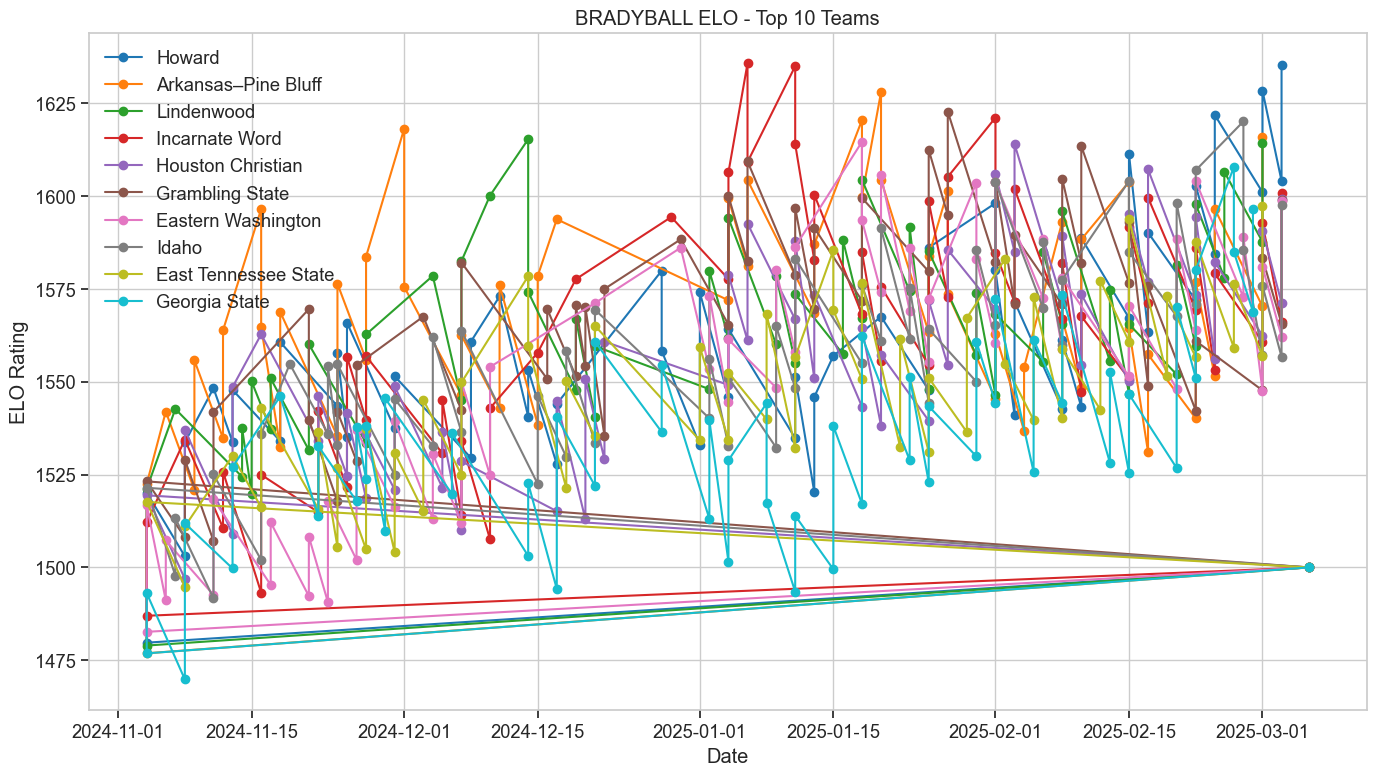

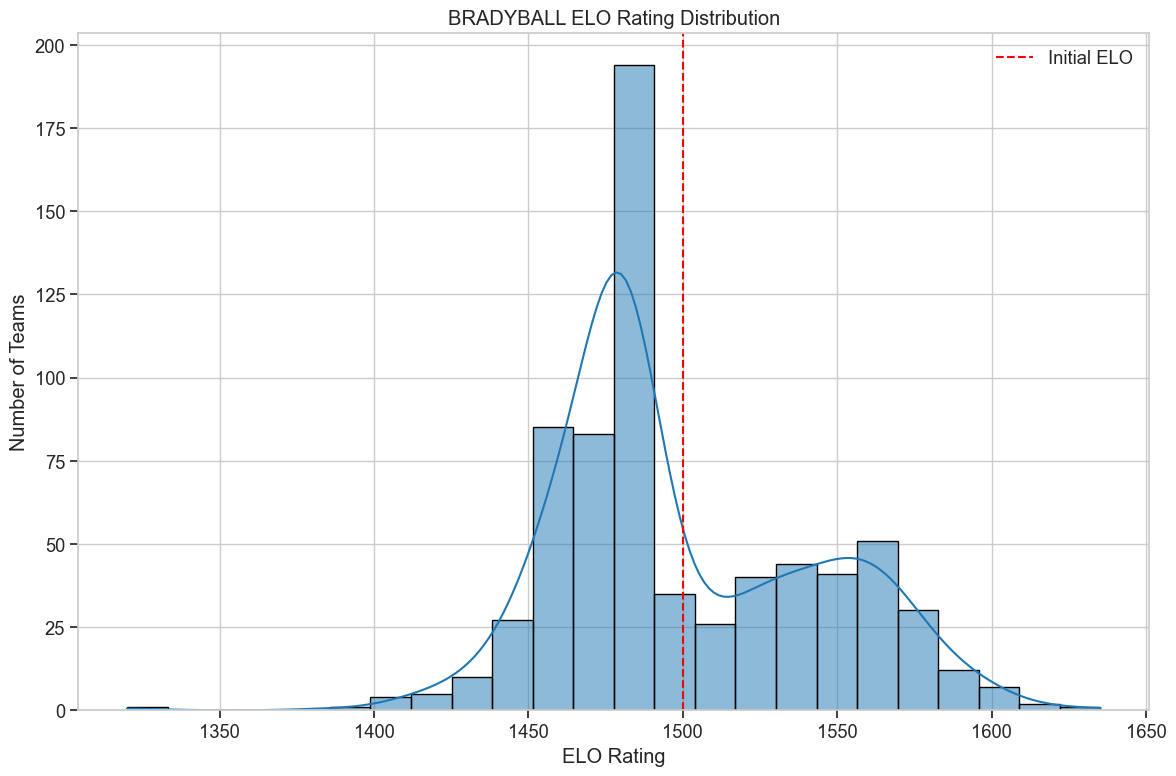